In [1]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [2]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [3]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [4]:
sys.path.append('..')
from helper import paths_input, formFH

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers

Using TensorFlow backend.


In [6]:
_,_,_,teDirTIF,teDirJPG = paths_input()
teDir = teDirTIF
nameList  = os.listdir(teDir);
print(teDir,"\n",len(nameList),nameList[:6]);

../Data/test-tif-v2 
 61191 ['test_28790.tif', 'test_28791.tif', 'test_28792.tif', 'test_28793.tif', 'test_28794.tif', 'test_28795.tif']


In [7]:
trL   = np.load('../Data-Keras/train-basin-020-1D-2-L-tif-V2.npy')
trM   = np.load('../Data-Keras/train-basin-020-1D-2-M-tif-V2.npy')
trMMM = np.load('../Data-Keras/train-basin-020-1D-2-MM-tif-v2.npy')
print(trL,'\n',trM,'\n',trMMM.tolist())

['haze' 'primary' 'agriculture' 'clear' 'water' 'habitation' 'road'
 'cultivation' 'slash_burn' 'cloudy' 'partly_cloudy' 'conventional_mine'
 'bare_ground' 'artisinal_mine' 'blooming' 'selective_logging' 'blow_down'] 
 [ 0.69  0.68  0.67  0.57  0.66  0.59  0.75  0.74  0.85  0.62  0.83  0.63
  0.85  0.83  0.67  0.82  0.74] 
 [[0.0, 34166.0], [1101.0, 24650.0], [0.0, 29443.0], [513.0, 39786.0], [0.0, 18.56877106965939], [0.0, 19.479418562110165]]


In [13]:
def formFHMMM (nf, bins, mmm, printOK=False) :
    nx = []
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                r,g,b = ni[:,:,0],ni[:,:,1],ni[:,:,2]
                for im,mm in zip([r,g,b],mmm.tolist()) :
                    im1 = np.clip(im.astype(np.float32),mm[0],mm[1])
                    im1 = (im1-mm[0])/(mm[1]-mm[0])*bins;
                    hh1 = np.divide(np.histogram(im1,bins=bins,density=False)[0],(0.0+im1.size))
                    nx.append(hh1)
                nx = np.array(nx).flatten(); 
            if (ni.shape[2]==4) :
                r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,1],ni[:,:,3]
                dv = np.divide((r-n),(r+n+0.01))
                dw = np.divide((g-n),(g+n+0.01))
                for im,mm in zip([r,g,b,n,dv,dw],mmm.tolist()) :
                    im1 = np.clip(im.astype(np.float32),mm[0],mm[1])
                    im1 = (im1-mm[0])/(mm[1]-mm[0])*bins;
                    hh1 = np.divide(np.histogram(im1,bins=bins,density=False)[0],(0.0+im1.size))
                    nx.append(hh1)
                nx = np.array(nx).flatten(); 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if len(nx)==0 and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [17]:
trX, trY, i, size = [], [], 0, len(nameList)
step=10; bins=[x for x in range(0,255+step,step)] # RGB -> 0..255
step=300; bins=[x for x in range(0,65535+step+1,step)] # BGRN -> 0..65535
bins=200
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(teDirJPG,nn+".jpg");
    nf = os.path.join(teDirTIF,nn);
    nx = formFHMMM(nf,bins,trMMM)
    if (nx is not None) :
        nx=nx.reshape(nx.shape+(1,))
        trX.append(nx)
        trY.append(nn)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)
    
print(datetime.datetime.now())

len(trX)
trX = np.array(trX);
trY = np.array(trY);
print(len(nameList),trX.shape,trY.shape)

2017-05-14 00:14:34.776188 61191 61191
2017-05-14 00:19:51.993034 	 5000 	 test_15649.tif
2017-05-14 00:26:04.882452 	 10000 	 test_32423.tif
2017-05-14 00:32:04.843721 	 15000 	 test_36264.tif
2017-05-14 00:38:11.814563 	 20000 	 test_10894.tif
2017-05-14 00:44:31.565729 	 25000 	 file_9502.tif
2017-05-14 00:50:37.431009 	 30000 	 file_14128.tif
2017-05-14 00:53:27.714757 	 35000 	 file_17389.tif
2017-05-14 00:55:56.772794 	 40000 	 test_19356.tif
2017-05-14 00:58:40.707176 	 45000 	 test_10134.tif
2017-05-14 01:01:02.586885 	 50000 	 test_24243.tif
2017-05-14 01:03:31.037947 	 55000 	 test_7049.tif
2017-05-14 01:05:55.242068 	 60000 	 file_10482.tif
2017-05-14 01:06:28.843260
61191 (61191, 1200, 1) (61191,)


In [18]:
trY=[os.path.splitext(yy)[0] for yy in trY.tolist()]

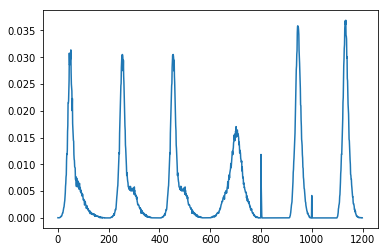

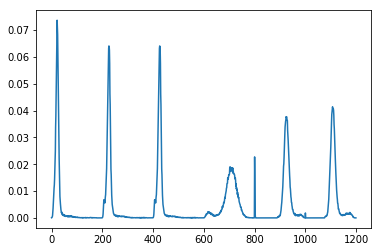

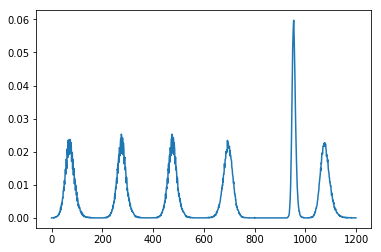

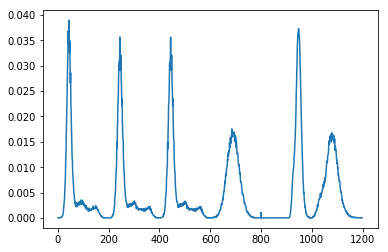

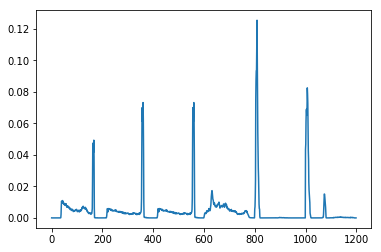

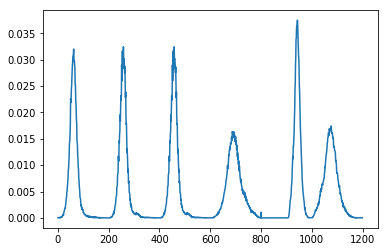

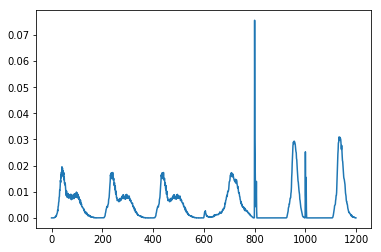

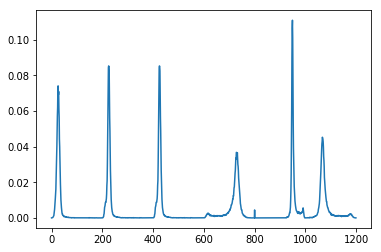

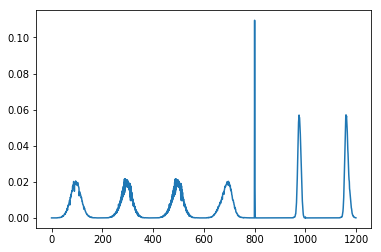

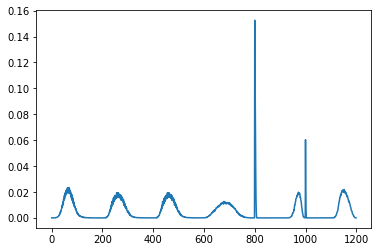

In [19]:
for i in range(trX.shape[0]-10,trX.shape[0]) :
    plt.plot(trX[i]); plt.show()

In [20]:
np.save('../Data-Keras/test-basin-020-1D-2-XX-tif-v2.npy',trX)
np.save('../Data-Keras/test-basin-020-1D-2-YY-tif-v2.npy',trY)

In [8]:
trX = np.load('../Data-Keras/test-basin-020-1D-2-XX-tif-v2.npy')
trY = np.load('../Data-Keras/test-basin-020-1D-2-YY-tif-v2.npy')
print(trX.shape,trY.shape)

(61191, 1200, 1) (61191,)


In [9]:
trL = np.load('../Data-Keras/train-basin-020-1D-2-L-tif-V2.npy')
trM = np.load('../Data-Keras/train-basin-020-1D-2-M-tif-V2.npy')
print(trL,'\n',trM)

['haze' 'primary' 'agriculture' 'clear' 'water' 'habitation' 'road'
 'cultivation' 'slash_burn' 'cloudy' 'partly_cloudy' 'conventional_mine'
 'bare_ground' 'artisinal_mine' 'blooming' 'selective_logging' 'blow_down'] 
 [ 0.69  0.68  0.67  0.57  0.66  0.59  0.75  0.74  0.85  0.62  0.83  0.63
  0.85  0.83  0.67  0.82  0.74]


In [11]:
import keras.backend as K
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    yy_pred = K.round(y_pred+(0.5-OK1))
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return((1+beta2)*(precision*recall)/(beta2*precision+recall+eps))

In [12]:
#
#
#

ss = trX.shape[1]
rr = trM.shape[0]

model = Sequential()
model.add(BatchNormalization(input_shape=(ss,1)))
#model.add(Dense(ss*10, input_shape=(ss,1))) # ?????
model.add(Dense(64)) # ?????
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(32768))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(rr,activation='sigmoid'))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['accuracy']) #['accuracy',fbeta_pred]) #['accuracy'])

In [13]:
model.load_weights('../Data-Keras/train-model-020-1D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 1200, 1)       4           batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1200, 64)      128         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1200, 64)      0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1200, 64)      0           activation_1[0][0]               
___________________________________________________________________________________________

In [15]:
trP = model.predict(trX, batch_size=512); 
trP.shape

(61191, 17)

In [16]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
#rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
wr = [trL.tolist().index(i) for i in weather_labels];
trM[np.array(wr)] = 2.0
print(wr,'\n',trL.tolist(),'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.68, 0.67, 2.0, 0.66, 0.59, 0.75, 0.74, 0.85, 2.0, 2.0, 0.63, 0.85, 0.83, 0.67, 0.82, 0.74]


In [17]:
# form result

In [18]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + trL[(trP[i,:]>trM)].tolist();
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
print(res[4:11],'\n',res[-6:])

[['test_4', 'cloudy'], ['test_5', 'clear primary'], ['test_6', 'clear primary agriculture'], ['test_7', 'clear primary habitation road'], ['test_8', 'clear primary'], ['test_9', 'clear primary'], ['test_10', 'partly_cloudy primary agriculture']] 
 [['file_20516', 'clear primary'], ['file_20517', 'clear primary'], ['file_20518', 'clear primary'], ['file_20519', 'clear primary water'], ['file_20520', 'partly_cloudy primary'], ['file_20521', 'clear primary agriculture']]


In [19]:
# form result file (submission) with time label

In [20]:
print(trL.tolist())
print(trM.tolist())
np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.48, 0.48, 2.0, 0.33, 0.39, 0.39, 0.37, 0.27, 2.0, 2.0, 0.28, 0.35, 0.2, 0.35, 0.29, 0.54]


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]], dtype=float32)

In [19]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-14-19-55-36
